# Comparision of Numerical Methods for solving ODEs

## Intro and Motivation

> "It's a mysterious and marvelous fact that our universe obeys the laws of nature that always turn out to be expressible in the language of calculus as sentences called differential equations."
-Steven Strogatz. Infinite Powers

While this may be an admittedly poetic take on the subject, differential equations do have important applications in physics, engineering, and [computer science](https://arxiv.org/abs/1806.07366).

So what exaclty is a differential equation? Well, per [wikipedia](https://en.wikipedia.org/wiki/Differential_equation):
> "In mathematics, a differential equation is an equation that relates one or more functions and their derivatives."

Seems fairly straight forward right? 

It is desireable to find an explicit *solution* to these differential equations, or rather, a function who is related to its own derivative in the way described by the differential equation. But sometimes (basically almost all the time), they can be incredibly difficult or impossible to solve.

Most introductory courses in ordinary differntial equations (Differential equations that don't involve partial derivatives, we refer to them as ODEs) will introduce several specific types of ODEs for which an explicit solution can be found (such as linear ODEs and harmonic oscilators), as well as techniques to solve simpler ones (such as [seperation of variables](https://en.wikipedia.org/wiki/Separation_of_variables) and [integrating factors](https://en.wikipedia.org/wiki/Integrating_factor).

For the differential equations that we don't yet have a known method for solving, we turn to numerical approximation algorithms to give us an idea of what the behavior of the solution is like. These numerical methods can be computationally arduous, so it is preferable to write code to compute them for us.

In this notebook, I will introduce a three different approximation algorithms written in python. These are ([Euler's Method](https://en.wikipedia.org/wiki/Euler_method), [Heun's Method](https://en.wikipedia.org/wiki/Euler_method), and the [Runge-Kutta Method](https://en.wikipedia.org/wiki/Runge–Kutta_methods)). We will then measure their respective accuracies against a differential equation that we know the solution for.

***
## Our Differential Equation

Our first step is to define our differential equation.

\begin{equation*}
\frac{dy}{dt} = -2ty
\end{equation*}

Why this particular equation you might ask? Well, it just so happens that we have a tool in our arsenal to explicitly solve this differential equation. Having a solution will help us measure the accuracy of our approximations. We will use the [seperation of variables](https://en.wikipedia.org/wiki/Separation_of_variables) technique outlined below.

\begin{align}
\frac{dy}{y} & = 2tdt\\
\int \frac{dy}{y} & = \int -tdt \\
ln(y) &= -t^2 + C \\
y &= e^{-t^2 + C} \\
\end{align}

Since y is a function of t, we can express our solution as

\begin{align}
y(t) &= e^{-t^2 + C} \\
\end{align}

For our example, we will use the initial conditions

\begin{align}
t &= 0 \\
y(0) &= 1\\
\end{align}

Plug these into our solution to find C

\begin{align}
1 &= e^{-(0)^2 + C} \\
\end{align}

Thus C = ln(1) = 0. Therefore we can write our solution as

\begin{align}
y(t) &= e^{-t^2} \\
\end{align}


We will be referencing back to these functions throughout this notebook, so I want to make sure that it is very clear what I will be calling them and what they mean:

- When we say say *the equation*, or the *differential equation* we are refering to
\begin{equation*}
f(t, y) = \frac{dy}{dt} = -2ty
\end{equation*}
and when we evaluate this function at a specific time (t) and solution value (y) we get the rate of change of the solution, or *slope*


- When we say *the solution* we are refering to the antiderivative of the differential equation (its solution)
\begin{align}
y(t) &= e^{-t^2} \\
\end{align}
and when we evaluate this function at a given value for t, we get the *value of the solution* at time t.


### Translating into Python

Our first step is to translate our differential equation into python. Considering differential equation are functions (in our case, of y and t) it is natural to want to create a function in python to evaluate our ODE at different values of y and t. In this case however, I wanted to use the sympy package as it has some powerful features we can exploit. We will create a sympy expression for our ODE that we will then pass into our approximation algorithm functions later on.

In [1]:
# Imports
import sympy as sp
import numpy as np

# Define our ODE
y,t = sp.symbols ('y t') #** don't forget to set y and t as symbols so we can evaluate our expressions
our_ode = sp.sympify('-2*t*y')
our_solution = sp.sympify('E**(-t**2)')

To demonstrate how sympy expressions work, we will use the subs method to pass in the value of 0 in for t into our solution.

In [2]:
our_solution.subs([(t,0)])

1

And we get 1 as expected.

Next, we have to define the time parameters.

These parameters are 
- the first time point (denoted t_0)
- the last time point (denoted t_n)
- the step count (n)
- the initial value of y (y_0)

We will put these into a dictionary called "our_params" just for the ease of passing them into our approximation algorithms down the line.

We will also define a function that returns a list of timestamps for which we want to approximate values of our solution. We will see how this will come in handy later down the line.

In [3]:
# time parameters for our approximation
# start time, end time, number of steps, initial value
our_params = {'t_0': 0., 't_n': 2., 'n': 10, 'y_0': 1.}

# function to return list of timestamps
def timestamps(param):
    # create list of time stamps
    t_0 = param['t_0']
    t_n = param['t_n']
    n = param['n']
    t_points = np.arange(t_0, t_n + (t_n-t_0)/n, (t_n-t_0)/n).tolist()
    return t_points[:(n+1)]

We will come back to revisit these paramaters when we start coding up our algorithms. But first, we must visit the mathematics of the methods.

***
## Euler's Method

The Euler Method is a rather intuitive approximation method. Consider what we are trying to accomplish at the most fundatmental level. We have a differential equation that models the change in a variable with respect to time, and our goal is to explicitly describe the variable as a function of time that is governed by the rate of change described by our differential equation. Recall that this is generally very difficult (if possible) for most differential equations, so we must come up with a reasonable way to estimate the behavior of our variable with respect to time.

Given the inital conditions for time and value, Euler's method attempts to model the values of our solution at specific points in time. The method achieves this in a stepwise fashion, where it approximates the value of the solution at points in time seperated by a constant time interval. These intervals are determined by the number of steps in our algorithm. In our case, we are using 10 steps between time 0 and time 2 by approximating the vaue of our solution at the following time points [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0].

***The end goal of the approximation algorithm is to get as close as possible to the real value of the solution to our differential equation at time 2 (given the initial conditions).***

For our case, the inital time value is 0 and the intial value of y is 1. We can use our differntial equation to get the value of the slope of our solution at these initial conditions. 

\begin{equation*}
f(t = 0, y = 1) = -2*(0)*(1) = 0
\end{equation*}

We find that the slope of our solution at the point t = 0 (with initial condition y = 1 at t = 0) is 0. Euler's method uses this slope value to approximate the value of our solution at the next time point, t = 0.2, using the formula for our differential equation and the length of our time step, 0.2, which we denote using *dt*:

\begin{align}
y_{t+1} &= y_t + m_t*dt \\
y_{0.2} &= y_{0} + m_{0}*dt \\
y_{0.2} &= 1 + 0*(0.2) \\
y_{0.2} &= 1 \\
\end{align}

We now have a value of our solution with which we can approximate a slope at time t = 0.2

\begin{equation*}
f(t = 0.2, y = 1) = -2*(0.2)*(1) = -0.4 \\
\end{equation*}

and can continue the process of approximating subsequent values using the slopes at the previous time points.

\begin{align}
y_{0.4} &= y_{0.2} + m_{0.2}*dt \\
y_{0.4} &= 1 + (-0.4)*(0.2) \\
y_{0.4} &= 0.92
\end{align}

From this point forward, we simply rinse, wash, and repeat to obtain the approximate values of our solution at each remaining time point.

### Euler's Method Function

For our Euler's Method approximation algorithm, we will define a function that takes in our differential equation as well as the time paramater dictionary we created above as arguments. The function will determine the size of the time step, (*dt* in our explanation above), and will use an approximation function that calculates the predicted value of our solution given the current value, its slope, and our time step. The last part of our function is a simple loop that iterates over our time points and calculates the approximated value of our solution at each point.

In [4]:
def euler(de, param):
    
    # size of each time step
    dt = (param['t_n']-param['t_0'])/param['n']
    
    # function to calculate the approximation
    def y_approx(t_k, y_k, dt):
        return y_k + de.subs([(y,y_k), (t,t_k)]) * dt
    
    y_hat = [param['y_0']]
    for k in range(0, param['n']):
        t_k = param['t_0'] + k * dt
        y_k = y_hat[len(y_hat)-1]
        y_hat.append(y_approx(t_k, y_k, dt))
    return np.array(y_hat).tolist()

our_euler_approx = euler(our_ode, our_params)

### Analyzing the Performance of Euler's Method

The accuracy of numerical approximation algorithm is generally measured by the difference between the predicted value of the solution at the final time point. In our case, we want to see the difference between our approximate value at time 2 and the real value at time 2. We will report the error as the absolute value of the difference to avoid reporting negative values.

In [5]:
# value of euler's method approximation at the last time_step
euler_at_n = our_euler_approx[-1] 
# value of the solution at the last time step
solution_at_n = our_solution.subs([(t,our_params['t_n'])]).evalf()

# error
euler_error = abs(euler_at_n - solution_at_n)
print(euler_error)

0.0127890466726292


We see that the absolute error for our Euler's Method approximation is 0.0128. This is a pretty good result, and we will compare this result with the error from other algorithms down the track.

### Plotting Euler's Method Solution

Above we determined the error of our Euler's Method approximation algorithm. While knowing how close we ended up getting is very important, I personally believe it is worth while looking at how we got there. In order to achieve this, let's create a function that will plot our approximation against the actual solution values.

In [6]:
# Plot Function
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_approx(approx, param, approx_lab, color):
    # time stamp
    time_stamp = timestamps(param)

    # solution (more granular than our time step for plotting purposes)
    solution_time_stamp = np.arange(0,2,0.01)
    solution_array = [our_solution.subs(t,x) for x in solution_time_stamp]

    # Plot
    fig=plt.figure()
    ax=fig.add_subplot(111)

    ax.plot(solution_time_stamp, solution_array, c='k', label="Solution",fillstyle='none')
    ax.plot(time_stamp, approx, c=color, label=approx_lab,fillstyle='none')
    ax.set_title(label = 'Numerical Approx via '+approx_lab)
    ax.set_xlabel(xlabel = 't')
    ax.set_ylabel(ylabel = 'y(t)')

    plt.legend(loc=3)
    plt.show()

<IPython.core.display.Javascript object>


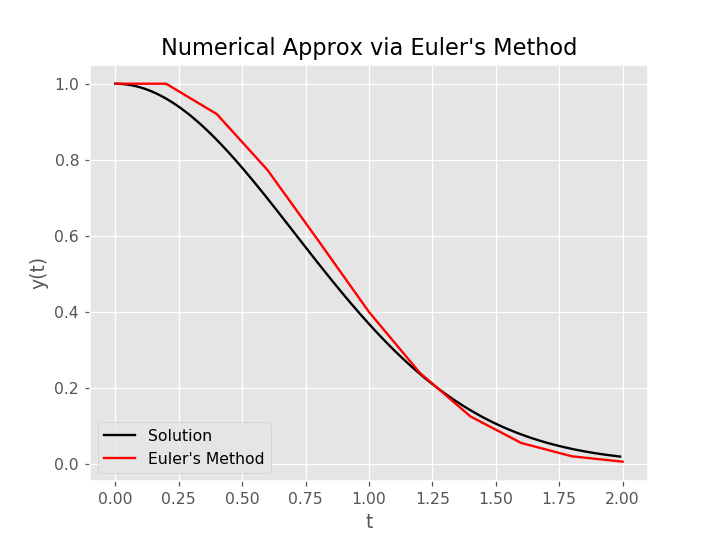

In [7]:
plot_approx(our_euler_approx, our_params, "Euler's Method", 'r')

It is interesting to observe how close the approximations were at each time step. As we move forward, we will be able to compare more sophisticated algorithms to Euler's Method and see how the accuracy improves.

***

## Heun's Method

Heun's Method is very similar to Euler's Method in the sense that it is using the slopes from our differential equation at specific time points to approximate the values of the solution, but there is one key difference.
Recall in Euler's Method how we used the following equation to approximate the value of the solution at an aribtrary time point: 

\begin{equation*}
y_{t+1} = y_t + m_t*dt \\
\end{equation*}

Where dt is the change in time, and m_t is the value of the differential equation at the given time and value:

\begin{equation*}
m_t = f(t, y_t) = -2*t*y
\end{equation*}

The difference in Heun's Method is that it uses the average of the slope at time t and time t+1 to approximate the value of the solution at time t. The recursive equation looks like this:

\begin{equation*}
y_{t+1} = y_t + \frac{(m_t + m_{t+1})}{2} *dt \\
\end{equation*}

But how do we know what the value of the slope is at time t+1 if we don't yet know the value of the solution at time t? Well, we can use Euler's Method! In this algorithm, we utilize Euler's Method to move one time step forward (t+1), calculate the slope at that time point, and then go back to time t and use the average of our slope at t and T+1 to calculate the value of our solution at time t+1. 

To paint a better picture of what is going on, I like to use the analogy of the Rectangle Rule vs the Trapazoid Rule for approximating integrals (essentially our whole task is to approximate the integral of a derivative). Euler's Method is analogous to a Rectangle Rule and Heun's Method is analogous to the Trapazoid Rule. For a refresher on what I am referencing here, you can read more on numerical integration techniques [here](https://en.wikipedia.org/wiki/Numerical_integration).

I know that can seem confusing. I have outlined the steps below for your reference to hopefully make the process more clear.

##### STEPS FOR APPROXIMATING SOLUTION VALUES USING HEUN'S METHOD
1. Calculate the value of the slope at time t from the differential equation.
2. Use the slope from (1) to calculate the value of the solution at time t+1 using Euler's Method.
3. Calculate the value of the slope at time t+1 from the differential equation using the value approximated from (2).
4. Go back to time t and approximate the value of the solution at time t+1 using the average of the slopes calculated from (1) and (3).




### Heun's Method Function

The function for our Heun's Method algorithm is very similar to the function we used for our Euler's Method algorithm, (this makes sense considering the two algorithms are effectively the same sans one term). The additions we have to make are in our *y_approx* function. We add a y_k_m term which is our approximation of the solution at time t+1 using our slope m, the m2 term which is our slope approximated at time t+1, and then we add the average of m and m2 in the returned value.

In [8]:
def heun(de, param):
    
    # size of each time step
    dt = (param['t_n']-param['t_0'])/param['n']
    
    # function to calculate the approximation
    def y_approx(t_k, y_k, dt):
        m = de.subs([(y,y_k), (t,t_k)])
        y_k_m = y_k + m * dt
        m2 = de.subs([(y,y_k_m), (t, t_k+dt)])
        return y_k + ((m + m2)/2) * dt
    
    y_hat = [param['y_0']]
    for k in range(0, param['n']):
        t_k = param['t_0'] + k * dt
        y_k = y_hat[len(y_hat)-1]
        y_hat.append(y_approx(t_k, y_k, dt))
    return y_hat

our_heun_approx = heun(our_ode, our_params)

### Analyzing the Performance of Heun's Method

In [9]:
# value of euler's method approximation at the last time_step
heun_at_n = our_heun_approx[-1] 
# value of the solution at the last time step
solution_at_n = our_solution.subs([(t,our_params['t_n'])]).evalf()

# error
heun_error = abs(heun_at_n - solution_at_n)

# error comparision
print(heun_error)
print('Heuns Method Imrovement: ' + str(round(100*(1-heun_error/euler_error),2)) + '%')

0.00693415601778322
Heuns Method Imrovement: 45.78%


When we use Heun's method over Euler's method, we decreased our absolute error by over 45 percent!

<IPython.core.display.Javascript object>


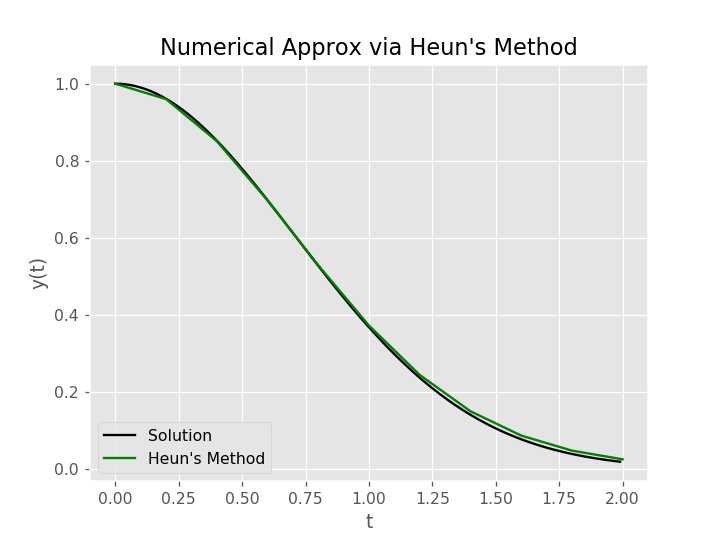

In [10]:
# Heun Plot 
plot_approx(our_heun_approx, our_params, "Heun's Method", 'g')

The improvment in accuracy is even evident in the graph shown above. The green line approximates the black solution line much better than the red line we saw above from our plot of the Euler's Method approximation

<hr>

## Runge-Kutta Method

Runge-Kutta metheds area  class of approximation methods developed by mathematicians Carl Runge and Wilhelm Kutta. When one refers to the "Runge-Kutta Method", they are most likely refereing to the 4th order method, commonly refered to as "RK4".

The Runge-Kutta method takes a page out of the Heun Method's playbook by again using an average of several slopes, but instead of using an arithmetic average of 2 slopes it uses a weighted average of 4 slopes. The four slopes are calculated as follows:

Assume an initial starting point of t_0 and a step size of h.

Slope 1: (denoted m)
- The first slope is simply the value of the differential equation at t_0 and the value (or approximated value) of the solution at t_0. (Same slope used in Euler's Method)
    
Slope 2: (denoted n)
- The second slope is a little more involved. It uses the slope m, but then uses that slope to approximate the value of the solution at the time point t_0 + h/2 (so halfway between t_0 and t_0 + h). The second slope n is then the value of the differential equation evaluated at t_0 + h/2 and the approximated value of the solution at t_0 + h/2. 

Slope 3: (denoted q)
- The third slope is similar to the second slope in that it is calculated from evaluating the ODE at t_0 + h/2, but it gets there a little bit differently. It uses the slope n (the one calculated in step 2) at the t_0 to project out to t_0 + h/2, where the third slope q is calculated as the value of the differention given the value of the solution just calculated at t_0 + h/2.

Slope 4: (denoted p)
- The fourth slope is calculated at time t + h (end of the interval). The value of the solution is approximated using the slope q and the time point t_0 to approximate the value of the solution at time t_0 + h. The differential equation is then evaluated at time t_0 + h with the value of the approximated solution to get the final slope, p.

Below we will generate a plot to give a visual of what these slopes represent. As a bonus, we can use the code we write below to help create our Runge-Kutta approximation function!

<IPython.core.display.Javascript object>


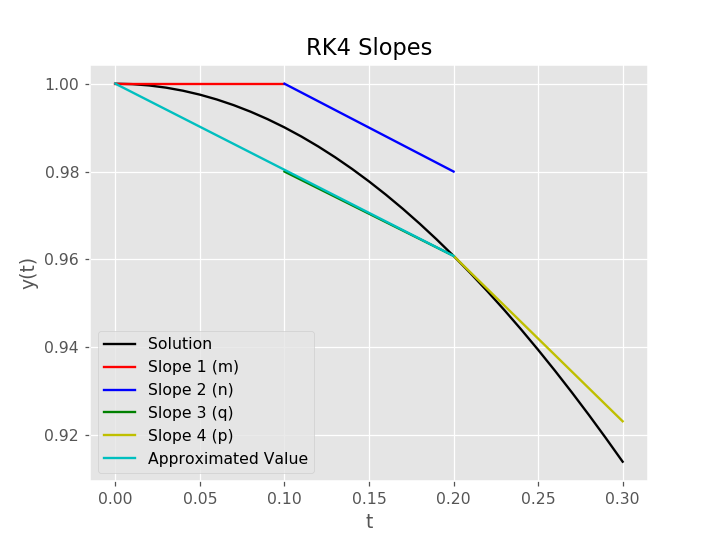

In [11]:
# Initial Conditions
t_k = our_params['t_0']
y_k = our_params['y_0']

# size of each time step
dt = (our_params['t_n']-our_params['t_0'])/our_params['n']
dt_half = dt/2

de = our_ode

# Slope 1 (m)
m = our_ode.subs([(y,y_k), (t,t_k)])
y_k_m = y_k + m * dt_half

# Slope 2 (n)
n = our_ode.subs([(y,y_k_m), (t, t_k+dt_half)])
y_k_n = y_k + n * dt_half

# Slope 3 (q)
q = our_ode.subs([(y,y_k_n), (t, t_k+dt_half)])
y_k_q = y_k + q * dt

# Slope 4 (p)
p = our_ode.subs([(y,y_k_q), (t, t_k+dt)])
y_k_p = y_k + p * dt

# approximate value
y_k_1 = y_k + ((m + 2 * n + 2 * q + p)/6) * dt

# solution (more granular than our time step for plotting purposes)
solution_time_stamp = np.arange(t_k,t_k + 1.5*dt,0.01)
solution_array = [our_solution.subs(t,x) for x in solution_time_stamp]

# plot slopes
fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(solution_time_stamp, solution_array, c = 'k', label="Solution",fillstyle='none')
ax.plot([t_k, t_k+dt/2], [y_k, y_k_m], c = 'r', label="Slope 1 (m)",fillstyle='none')
ax.plot([t_k+dt/2, t_k+dt], [y_k_m, y_k_n], c = 'b', label="Slope 2 (n)",fillstyle='none')
ax.plot([t_k+dt/2, t_k+dt], [y_k_n, y_k_q], c = 'g', label="Slope 3 (q)",fillstyle='none')
ax.plot([t_k+dt, t_k+dt+dt/2], [y_k_q, y_k_p], c = 'y', label="Slope 4 (p)",fillstyle='none')
ax.plot([t_k, t_k+dt], [y_k, y_k_1], c = 'c', label="Approximated Value",fillstyle='none')

ax.set_title(label = 'RK4 Slopes')
ax.set_xlabel(xlabel = 't')
ax.set_ylabel(ylabel = 'y(t)')

plt.legend(loc=3)
plt.show()

### Runge-Kutta Function

Having already written the code to calculate the four slopes in the RK4 algorithm, we can insert it into our y_approx function to build our RK4 algorithm function.

In [12]:
def runge_kutta(de, param):
    
    # size of each time step
    dt = (param['t_n']-param['t_0'])/param['n']
    
    # function to calculate the approximation
    def y_approx(t_k, y_k, dt):
        dt_half = dt/2
        
        m = de.subs([(y,y_k), (t,t_k)])
        y_k_m = y_k + m * dt_half
        
        n = de.subs([(y,y_k_m), (t, t_k+dt_half)])
        y_k_n = y_k + n * dt_half
        
        q = de.subs([(y,y_k_n), (t, t_k+dt_half)])
        y_k_q = y_k + q * dt
        
        p = de.subs([(y,y_k_q), (t, t_k+dt)])
        
        return y_k + ((m + 2 * n + 2 * q + p)/6) * dt
    
    y_hat = [param['y_0']]
    for k in range(0, param['n']):
        t_k = param['t_0'] + k * dt
        y_k = y_hat[len(y_hat)-1]
        y_hat.append(y_approx(t_k, y_k, dt))
    return y_hat

our_rk_approx = runge_kutta(our_ode, our_params)

### Analyzing the Performance of the Runge-Kutta Method

In [13]:
# value of euler's method approximation at the last time_step
rk_at_n = our_rk_approx[-1] 
# value of the solution at the last time step
solution_at_n = our_solution.subs([(t,our_params['t_n'])]).evalf()

# error
rk_error = abs(rk_at_n - solution_at_n)

print(rk_error)
print('Runge-Kutta Improvement Over Eulers Method: ' + str(round(100*(1-rk_error/euler_error),2)) + '%')
print('Runge-Kutta Improvement Over Heun Method: ' + str(round(100*(1-rk_error/heun_error),2)) + '%')

0.000142055256679326
Runge-Kutta Improvement Over Eulers Method: 98.89%
Runge-Kutta Improvement Over Heun Method: 97.95%


We can see from the percent imrpovements in the absolute error that the Runge-Kutta algorithm generates a demonstrably more accurate approximation than our previous two algorithms. (We would certainly hope so given that it is a relatively more complicated algorithm)

<IPython.core.display.Javascript object>


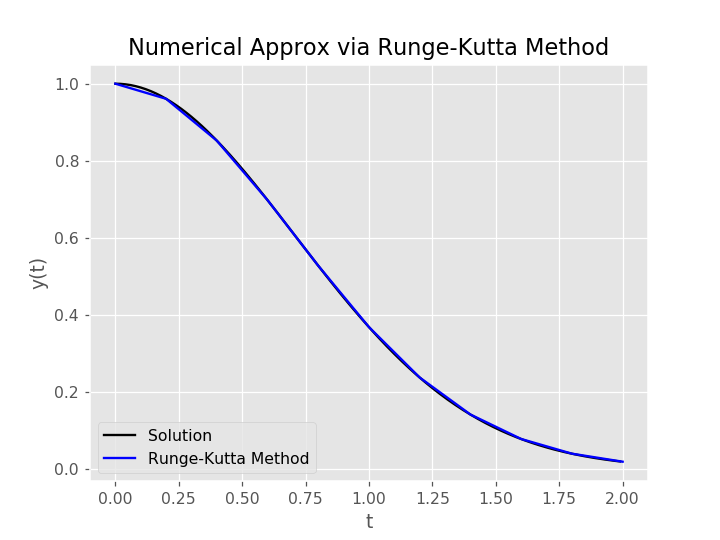

In [14]:
# Runge-Kutta Plot
plot_approx(our_rk_approx, our_params, "Runge-Kutta Method", 'b')

<hr>

## Improving the Granularity

While we have deomonstrated that different approximation algorithms can help us improve accuracy, we haven't tried simply increaseing the number of time points. (Or rather, decreasing the length of the time step)

Recall what is [actually happening](https://en.wikipedia.org/wiki/Integral) as the number of time points in our finite interval approaches infintiy. When we increase the number of timesteps, we will approach the integral of our differential equation (the real solution).

This will increase the computational cost of running our algorithms, (and improved algorithms were invented for the sole purpose of achieveing better accuracy without having to do this), but we have computers... lets use them!

<IPython.core.display.Javascript object>


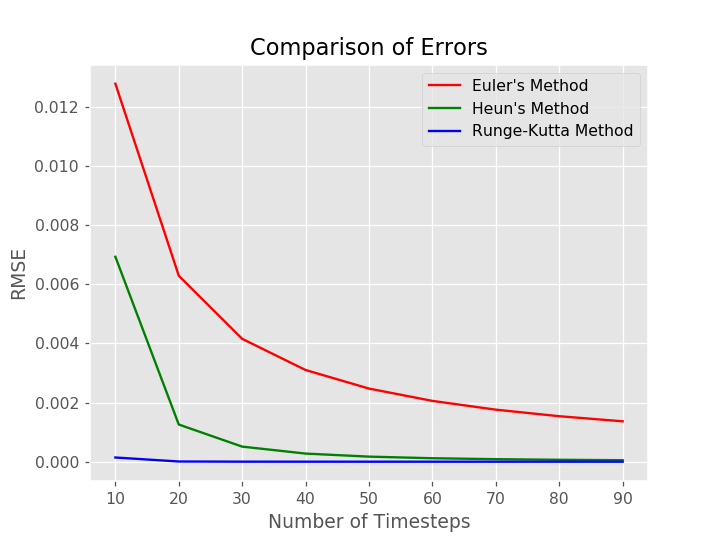

In [15]:
n_list = np.arange(10,100,10)

euler_error_list = []
heun_error_list = []
rk_error_list = []
for n in n_list:
    # define paramaters
    n_params = {'t_0': 0., 't_n': 2., 'n': n, 'y_0': 1.}
    
    # ground truth value
    solution_at_n = our_solution.subs([(t,our_params['t_n'])]).evalf()

    
    # approximation values
    euler_approx = euler(our_ode, n_params)
    heun_approx = heun(our_ode, n_params)
    rk_approx = runge_kutta(our_ode, n_params)
   
    # append errors to list
    # euler_error_list.append(rmse(euler_approx, solution_values, n_params))
    # heun_error_list.append(rmse(heun_approx, solution_values, n_params))
    # rk_error_list.append(rmse(rk_approx, solution_values, n_params))
    euler_error_list.append(abs(solution_at_n - euler_approx[-1]))
    heun_error_list.append(abs(solution_at_n - heun_approx[-1]))
    rk_error_list.append(abs(solution_at_n - rk_approx[-1]))
    
# plot errors
fig=plt.figure()
ax=fig.add_subplot(111)

ax.plot(n_list, euler_error_list, color = 'r', label="Euler's Method",fillstyle='none')
ax.plot(n_list, heun_error_list, color = 'g', label="Heun's Method",fillstyle='none')
ax.plot(n_list, rk_error_list, color = 'b', label="Runge-Kutta Method",fillstyle='none')
ax.set_title(label = 'Comparison of Errors')
ax.set_xlabel(xlabel = 'Number of Timesteps')
ax.set_ylabel(ylabel = 'RMSE')

plt.legend(loc=1)
plt.show()

It is cool to see how the errors converge for each respective algorithm. It is apparent that Euler's method is limited in its potential, while Heun's Method and the RK4 algorithms converge to much smaller errors much faster.

There are several interesting features of this plot, for example if you zoom into the range between 10 and 100 you can see that Heun's Method seems to approach a similar error to that of the RK4 method, but never quite reaches it.

There is an interesting observation to be made about how the Euler's Method error is related to the number of timesteps, we shall explore further.

***

## Global Truncation Error of Euler's Method

Global truncation error is defined as the error at a the final time point. In our case, it is the error at time 2. Consider our approximation for the solution's value using Euler's Method. At time 0 we have our initial conditions so there is no error. When we project out to the next time step, we are approximating the value of the solution using the slope at time 0 and introduce error (called the *Local Truncation Error*). Then on top of that, we use this approximation to calculate the slope at the this time step (more local truncation error) and approximate the solution's value at the next time step (add on some more local truncation error for good measure). The additive result of all these compounding errors is called the "Global Truncation Error".

To analyze the effect that the number of steps has on the global trunction error, let's loop over different step counts from 10 to 500 by 10 and calculate the error at each number. Let's make a simple plot to help us think about what is really happening.

<IPython.core.display.Javascript object>


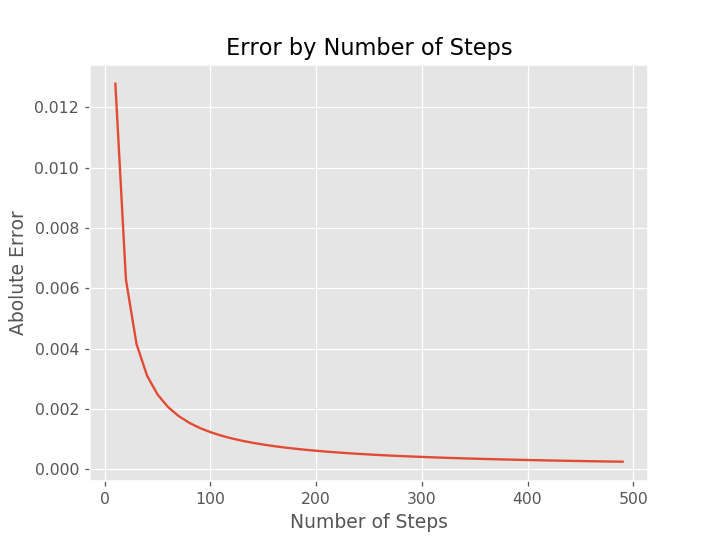

In [16]:
# list of step counts to loop over
n_list = np.arange(10,500,10)

# initialize list
error_list = []
for n in n_list:
    # insert the number of steps into our parameters
    n_params = {'t_0': 0., 't_n': 2., 'n': n, 'y_0': 1.}
    
    # ground truth value
    solution_at_n = our_solution.subs([(t,our_params['t_n'])]).evalf()
    # approximation values
    approx = euler(our_ode, n_params)[-1]
    # append the error to list
    error_list.append(abs(approx - solution_at_n))
    
# Plot of errors v step count
fig, ax = plt.subplots()
ax.plot(n_list, error_list)
ax.set(xlabel='Number of Steps', ylabel='Abolute Error',
       title='Error by Number of Steps')
plt.show()

### Evaluating the Error Relationship

If we can remember back to our algebra days, we might recognize the shape of the curve above as being similar to the function

\begin{equation*}
f(x) = \frac{1}{x}\\
\end{equation*}

Well, that is because it is very similar. In fact the error with respect to step count can be modeled by the function

Let x be the number of time steps in our approximation algorithm and let f(x) be the global truncation error, then:

\begin{equation*}
f(x) = \frac{K}{x}\\
\end{equation*}
For some constant K.

But how do we find K? We will demonstrate one method of approximating this value using ordinary least squares.

Consider in the case of linear regression, if we simply rewrite the function as 

\begin{equation*}
y = K * \frac{1}{x}\\
\end{equation*}

and regress y (the error) onto 1/k (1 divided by the step count) to estimate the parameter K.

In [17]:
# create an array of 1/(step count)
n_list_transformed = np.array([float(1/i) for i in n_list]).reshape(-1,1)
error_list = np.array(error_list)

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(n_list_transformed, error_list)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

To get our value of K, we will grab the first value in the coef_ attribute of the regressor class.

In [18]:
K = regressor.coef_[0]
print('K Estimate: ' + str(K))

K Estimate: 0.12733495937131162


To analyze the quality of the fit, let's look at the r-squared value of our model.

In [19]:
from sklearn.metrics import r2_score
predicted = regressor.predict(n_list_transformed)

print('r-squared: ' + str(r2_score(error_list, predicted)))

r-squared: 0.9998653418287083


As we can see our model is able to explain nearly all of the variance in our data. Let's plot our model against the observed errors to visually inspect our model's fit.

<IPython.core.display.Javascript object>


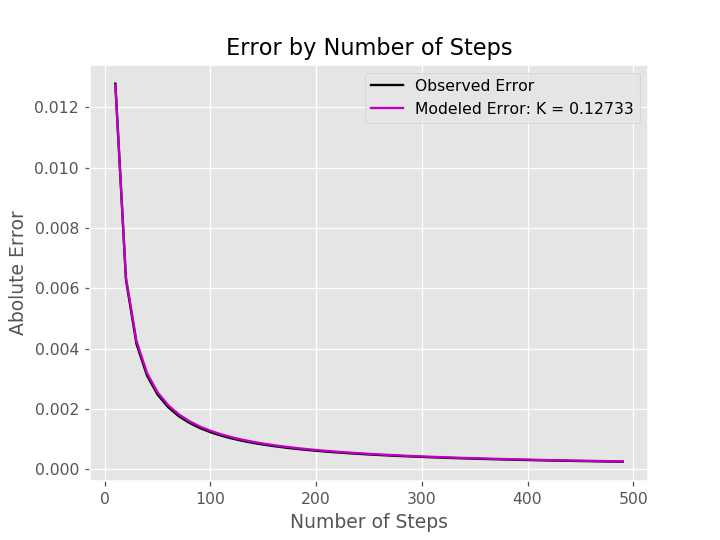

In [20]:
# Plot of errors and K
fig, ax = plt.subplots()
ax.plot(n_list, error_list, label = 'Observed Error', c = 'k')
ax.plot(n_list, [K/i for i in n_list], label = 'Modeled Error: K = ' + str(round(K,5)), c = 'm')
ax.set(xlabel='Number of Steps', ylabel='Abolute Error',title='Error by Number of Steps')
plt.legend(loc=1)
plt.show()